In [3]:
gethostname()

"n001801"

# Exercise: Cache Bandwidths

In this exercise you will benchmark a **Schoenauer triad** kernel (i.e. `y[i] = a[i] * x[i] + y[i]`) and see how the observed performance is effected by the memory hierarchy, i.e. different cache levels.

**Hint:** On most systems, you can programmatically query the cache sizes via

```julia
using CpuId
cachesize()
```

(It doesn't work on Apple silicon.)

## Tasks

1) Inspect the code below and implement the missing piece (look for the TODO annotation).

In [4]:
using Plots
using BenchmarkTools
using CpuId
using Statistics

"""
SDAXPY: `y[i] = a[i] * x[i] + y[i]` (Schoenauer triad without write-allocate.)

The arguments `y, a, x` are vectors of length `n`.
"""
function sdaxpy!(y, a, x, n)
    #
    # TODO: Implement the SDAXPY kernel. Use `@inbounds` to turn-off bound checks.
    #
    for i in 1:n
        @inbounds y[i] = a[i] * x[i] + y[i] # 8 bytes x 4 = 32 bytes data transfer
    end
end

"""
    vector_lengths(lo::Integer, hi::Integer, ni::Integer; factor::Integer=32)

Given some lower (`lo`) and upper (`hi`) bound in bytes, returns ≤ ni distinct integers
that are
- more or less evenly separated between lo and hi
- multiples of `factor`

These integers are to be used as vector lengths for the inputs to `sdaxpy!` and determine
the number of loop iterations therein.
"""
function vector_lengths(lo::Integer, hi::Integer, ni::Integer; factor::Integer=32)
    r_log = range(log10(lo / 32), log10(hi / 32), ni)
    r = round.(Integer, exp10.(r_log))
    r_factor = r .& (~(factor-1)) # biggest multiple of factor <= number
    return unique(r_factor)
end

"""
Perform a benchmark of the SDAXPY kernel (Schoenauer triad without write-allocate).
See `vector_lengths` for explanations of the input arguments.
"""
function bench(lo, hi, n; nbench, kwargs...)
    ts = Float64[]
    Ns = vector_lengths(lo, hi, n; kwargs...)
    for n in Ns
        y = fill(1.2, n)
        a = fill(0.8, n)
        x = fill(3.14, n)
        t = @belapsed for i in 1:$nbench
            sdaxpy!($y, $a, $x, $n)
        end samples = 30
        push!(ts, t / nbench)
        println("finished n = $n, time: ", ts[end], " sec bandwidth: ", 32.0e-9 * n / ts[end], " GB/s")
        flush(stdout)
    end
    return Ns, ts
end

function plot_results(Ns, ts)
    p = plot(Ns, Ns ./ ts .* 32.0e-9, marker=:circle, label="sdaxpy!", frame=:box, ms=2, xscale=:log10)
    ylabel!(p, "bandwidth [GB/s]")
    xlabel!(p, "vector size n")
    L1, L2, L3 = cachesize()
    mem = 4 * sizeof(Float64) # four arrays a, b, c, and d in `sdaxpy!`
    nL1 = L1 / mem
    nL2 = L2 / mem
    nL3 = L3 / mem
    vline!(p, [nL1], color=:orange, lw=2, label="L1 = $(floor(Int, nL1)) ($(L1/1024) KiB)")
    vline!(p, [nL2], color=:red, lw=2, label="L2 = $(floor(Int, nL2)) ($(L2/1024) KiB)")
    vline!(p, [nL3], color=:purple, lw=2, label="L3 = $(floor(Int, nL3)) ($(L3/1024) KiB)")
    return p
end

"""
Will perform the benchmark and save a plot of the results as png/svg files.
"""
function main()
    L1, L2, L3 = cachesize()
    Ns1, ts1 = bench(1024, L1, 12; nbench=2^24, factor=32)
    Ns2, ts2 = bench(round(Integer, L1 * 1.5), L2, 10; nbench=2^14, factor=64)
    Ns3, ts3 = bench(round(Integer, L2 * 1.5), L3, 10; nbench=2^10, factor=128)
    Ns4, ts4 = bench(round(Integer, L3 * 1.5), L3 * 32, 8; nbench=2^4, factor=64)
    p = plot_results(vcat(Ns1, Ns2, Ns3, Ns4), vcat(ts1, ts2, ts3, ts4))
    savefig(p, "sdaxpy_contiguous.svg")
    println("L1 bandwidth:\t", round(median(32.0e-9 .* Ns1 ./ ts1); digits=2), " GB/s")
    println("L2 bandwidth:\t", round(median(32.0e-9 .* Ns2 ./ ts2); digits=2), " GB/s")
    println("L3 bandwidth:\t", round(median(32.0e-9 .* Ns3 ./ ts3); digits=2), " GB/s")
    println("Memory bandwidth:\t", round(median(32.0e-9 .* Ns4 ./ ts4); digits=2), " GB/s")
    return p
end

main

2) Run the benchmark by calling the `main()` function. (Note that this can take up to ~7 minutes.)

finished n = 32, time: 5.3025391697883605e-9 sec bandwidth: 193.11502795383797 GB/s
finished n = 64, time: 9.488782584667206e-9 sec bandwidth: 215.8337997236163 GB/s
finished n = 96, time: 1.4005107343196869e-8 sec bandwidth: 219.3485508336541 GB/s
finished n = 128, time: 1.84252490401268e-8 sec bandwidth: 222.30364382482247 GB/s
finished n = 192, time: 2.7359531462192535e-8 sec bandwidth: 224.56524917066812 GB/s
finished n = 288, time: 4.085115951299667e-8 sec bandwidth: 225.5994715907136 GB/s
finished n = 384, time: 5.4306426525115965e-8 sec bandwidth: 226.27156280144806 GB/s
finished n = 544, time: 8.181006509065628e-8 sec bandwidth: 212.7855537177443 GB/s
finished n = 736, time: 1.03530826151371e-7 sec bandwidth: 227.4878012232313 GB/s
finished n = 1024, time: 1.495101158618927e-7 sec bandwidth: 219.169116491548 GB/s
finished n = 1536, time: 3.548743896484375e-7 sec bandwidth: 138.50534564833853 GB/s
finished n = 2112, time: 4.907521362304687e-7 sec bandwidth: 137.7151417396194 GB/

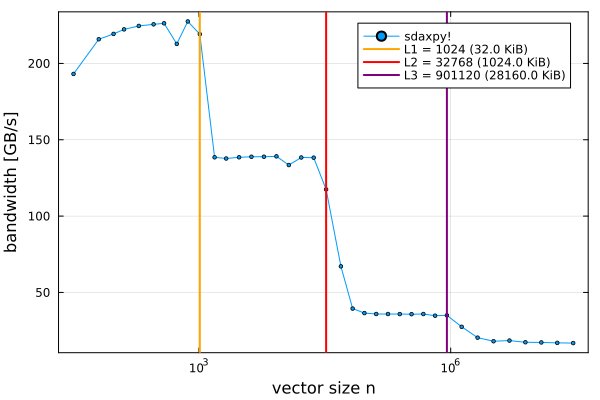

In [5]:
@time main()

* **Questions**
  * Do you understand the trend of the resulting plot?
  * Which bandwidth estimates (in GB/s) do you obtain for L1, L2, L3, and main memory? (Check the textual output of the benchmark.) Fill out the table below.
  
HPC cluster name: HLRS Training, CPU: Intel Xeon Gold 6138:

|  measurements   |  bandwidth [GB/s] |
|:---------------:|:-----------------:|
|  L1D cache      |  222              |
|  L2  cache      |  138              |
|  L3  cache      |  35               |
|  main memory    |  17               |


Let's now investigate the performance impact of **strided data access** in comparison to the contiguous data access (as benchmarked above).

3) Copy the entire code from above in the cell below and modify the `sdaxpy!` function such that it only performs the SDAXPY computation to every other vector element (i.e. instead of `1:n` you iterate over `1:2:n`). This corresponds to a stride size of 2.

4) Since we now only perform half as many operations and thus only half of the data transfer, we need to account for this change in all bandwidth computations. Specifically, check all lines that contain `32.0e-09` and insert an extra factor of 0.5.

In [6]:
using Plots
using BenchmarkTools
using CpuId

"""
SDAXPY: `y[i] = a[i] * x[i] + y[i]` (Schoenauer triad without write-allocate.)

The arguments `y, a, x` are vectors of length `n`.
"""
function sdaxpy!(y, a, x, n)
    #
    # TODO: Implement the SDAXPY kernel. Use `@inbounds` to turn-off bound checks.
    #
    for i in 1:2:n
        @inbounds y[i] = a[i] * x[i] + y[i] # 8 bytes x 4 = 32 bytes data transfer
    end
end

"""
    vector_lengths(lo::Integer, hi::Integer, ni::Integer; factor::Integer=32)

Given some lower (`lo`) and upper (`hi`) bound in bytes, returns ≤ ni distinct integers
that are
- more or less evenly separated between lo and hi
- multiples of `factor`

These integers are to be used as vector lengths for the inputs to `sdaxpy!` and determine
the number of loop iterations therein.
"""
function vector_lengths(lo::Integer, hi::Integer, ni::Integer; factor::Integer=32)
    r_log = range(log10(lo / 32), log10(hi / 32), ni)
    r = round.(Integer, exp10.(r_log))
    r_factor = r .& (~(factor-1)) # biggest multiple of factor <= number
    return unique(r_factor)
end

"""
Perform a benchmark of the SDAXPY kernel (Schoenauer triad without write-allocate).
See `vector_lengths` for explanations of the input arguments.
"""
function bench(lo, hi, n; nbench, kwargs...)
    ts = Float64[]
    Ns = vector_lengths(lo, hi, n; kwargs...)
    for n in Ns
        y = fill(1.2, n)
        a = fill(0.8, n)
        x = fill(3.14, n)
        t = @belapsed for i in 1:$nbench
            sdaxpy!($y, $a, $x, $n)
        end samples = 30
        push!(ts, t / nbench)
        println("finished n = $n, time: ", ts[end], " sec bandwidth: ", 0.5 * 32.0e-9 * n / ts[end], " GB/s")
        flush(stdout)
    end
    return Ns, ts
end

function plot_results(Ns, ts)
    p = plot(Ns, Ns .* 0.5 ./ ts .* 32.0e-9, marker=:circle, label="sdaxpy!", frame=:box, ms=2, xscale=:log10)
    ylabel!(p, "bandwidth [GB/s]")
    xlabel!(p, "vector size n")
    L1, L2, L3 = cachesize()
    mem = 4 * sizeof(Float64) # four arrays a, b, c, and d in `sdaxpy!`
    nL1 = L1 / mem
    nL2 = L2 / mem
    nL3 = L3 / mem
    vline!(p, [nL1], color=:orange, lw=2, label="L1 = $(floor(Int, nL1)) ($(L1/1024) KiB)")
    vline!(p, [nL2], color=:red, lw=2, label="L2 = $(floor(Int, nL2)) ($(L2/1024) KiB)")
    vline!(p, [nL3], color=:purple, lw=2, label="L3 = $(floor(Int, nL3)) ($(L3/1024) KiB)")
    return p
end

"""
Will perform the benchmark and save a plot of the results as png/svg files.
"""
function main()
    L1, L2, L3 = cachesize()
    Ns1, ts1 = bench(1024, L1, 12; nbench=2^24, factor=32)
    Ns2, ts2 = bench(round(Integer, L1 * 1.5), L2, 10; nbench=2^14, factor=64)
    Ns3, ts3 = bench(round(Integer, L2 * 1.5), L3, 10; nbench=2^10, factor=128)
    Ns4, ts4 = bench(round(Integer, L3 * 1.5), L3 * 32, 8; nbench=2^4, factor=64)
    p = plot_results(vcat(Ns1, Ns2, Ns3, Ns4), vcat(ts1, ts2, ts3, ts4))
    savefig(p, "sdaxpy_strided.svg")
    println("L1 bandwidth:\t", round(median(32.0e-9 .* 0.5 .* Ns1 ./ ts1); digits=2), " GB/s")
    println("L2 bandwidth:\t", round(median(32.0e-9 .* 0.5 .* Ns2 ./ ts2); digits=2), " GB/s")
    println("L3 bandwidth:\t", round(median(32.0e-9 .* 0.5 .* Ns3 ./ ts3); digits=2), " GB/s")
    println("Memory bandwidth:\t", round(median(32.0e-9 .* 0.5 .* Ns4 ./ ts4); digits=2), " GB/s")
    return p
end

main

5) Run the benchmark for the strided SDAXPY. How do the results compare to the contiguous case? What's the reason?

finished n = 32, time: 1.086222916841507e-8 sec bandwidth: 47.13581273803184 GB/s
finished n = 64, time: 1.9570036172866822e-8 sec bandwidth: 52.324890508876045 GB/s
finished n = 96, time: 2.8283307015895845e-8 sec bandwidth: 54.30765218284885 GB/s
finished n = 128, time: 3.709153479337692e-8 sec bandwidth: 55.21475483310795 GB/s
finished n = 192, time: 5.967618662118912e-8 sec bandwidth: 51.47782011441781 GB/s
finished n = 288, time: 8.578363883495331e-8 sec bandwidth: 53.716536889577945 GB/s
finished n = 384, time: 1.1251157158613204e-7 sec bandwidth: 54.60771646315976 GB/s
finished n = 544, time: 1.5541880130767822e-7 sec bandwidth: 56.0035203383723 GB/s
finished n = 736, time: 2.0838659447431564e-7 sec bandwidth: 56.51035293180259 GB/s
finished n = 1024, time: 2.870089735388756e-7 sec bandwidth: 57.08532314506458 GB/s
finished n = 1536, time: 5.476282958984375e-7 sec bandwidth: 44.877155150795645 GB/s
finished n = 2112, time: 8.3642138671875e-7 sec bandwidth: 40.40068862008032 GB/s

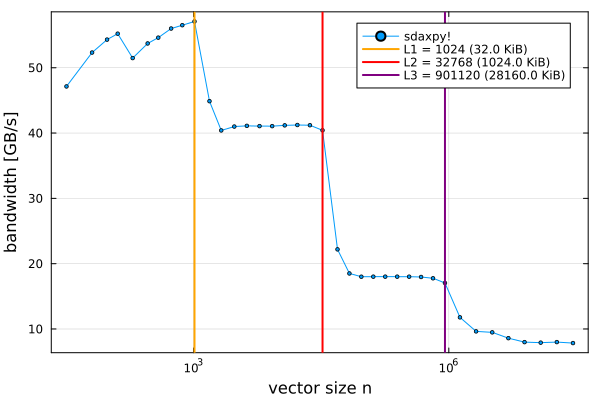

In [7]:
@time main()